In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

from utils.data_processing import load_pore_matrices

****
# Problem description
****

Probleme physique:
- Input: grille dans le carré unité avec 0 si pas de pores et 1 si des pores
- Output: density factor qui est le ratio du volume des pores / volume du cube

Problème inverse:
- Input: Density factor
- Output: grille avec 0 ou 1 i.e. distribution jointe de bernoulli

Goal: Il faut apprendre la distribution de la grille (joint bernoulli distributions) conditionnellement au density factor.

Challenges:
- La grille est sparse, donc le modèle a tendence à vouloir apprendre la matrice remplie de 0 ce qui a de grande chances de minimiser la loss. Idée: faire une weighted loss où on focus sur tous les 1 + quelques 0 tirés aléatoirement (negative sampling)
- Les 1 adjacents sont probablement un même pore mais plus gros. Est-il important de calculer ces gros pores ainsi que leur volume, ou alors juste l'agencement de 1 suffit?

Idée principale:
- GAN: Espace latent (inputs), serait tiré dans la distribution des density factors + outputs = matries reconstruites
- Autre idée: Faire un U-net ou VAE où la distribution à priori = la distribution du density factor (1D). L'encoder apprendrait le problème physiaue, alors que le décoder le problème inverse. 
- Comme l'input est une matrice en 3D, et qu'on cherche les patterns de cette matrice, on aurait envie d'utiliser des CNN dans l'encoder et le decoder. 

****
# Load data
****

In [2]:
import os
import numpy as np

data_folder = os.path.join(parent_dir, "data")
npy_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".npy")]

data_dict, grid_dict, densities_dict = load_pore_matrices(npy_files)


****
# Visualisation
****

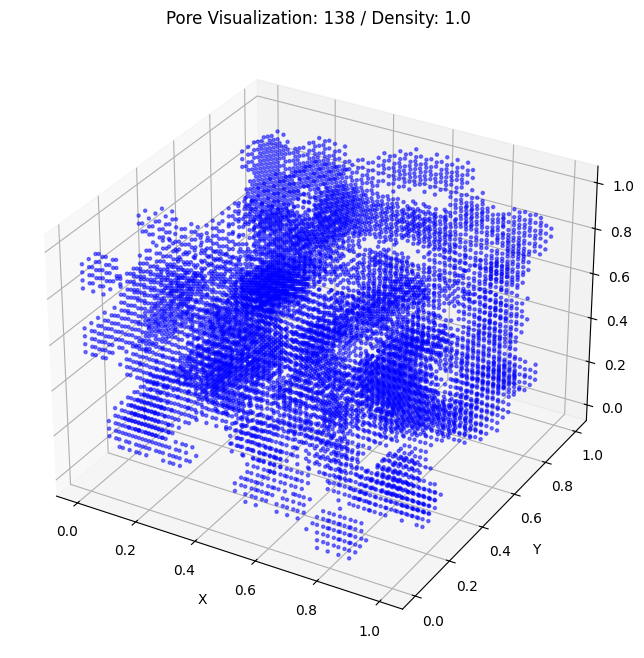

In [46]:
index = "138"
data_to_plot = data_dict[index]

# Extract only the points inside pores (occupancy == 1)
pores = data_to_plot[data_to_plot[:, 3] == 1]

# Extract x, y, z coordinates
x, y, z = pores[:, 0], pores[:, 1], pores[:, 2]

# Plot 3D scatter of pores
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', marker='o', alpha=0.5, s=5)  # Blue dots for pores

# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(f"Pore Visualization: {index} / Density: {densities_dict[index]}")

# Show the plot
plt.show()

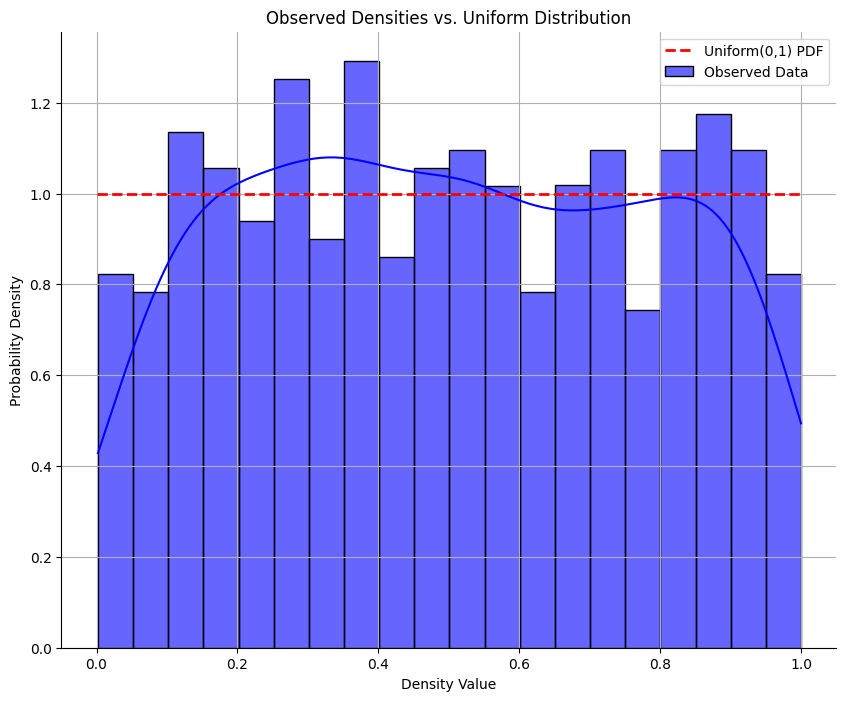

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

# Convert dictionary values to a NumPy array
density_values = np.array(list(densities_dict.values()))

# Generate the ideal uniform distribution PDF
x_range = np.linspace(0, 1, 100)
uniform_pdf = uniform.pdf(x_range, loc=0, scale=1)

# histogram of density values
plt.figure(figsize=(10, 8))
sns.histplot(density_values, bins=20, kde=True, stat="density", label="Observed Data", color="blue", alpha=0.6)

# uniform distribution
plt.plot(x_range, uniform_pdf, color="red", linestyle="dashed", linewidth=2, label="Uniform(0,1) PDF")


plt.xlabel("Density Value")
plt.ylabel("Probability Density")
plt.title("Observed Densities vs. Uniform Distribution")
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(True)
plt.show()

In [29]:
from scipy.stats import ks_1samp

# Perform KS test to verify if the distribution of densities is uniform
ks_stat, p_value = ks_1samp(density_values, uniform(loc=0, scale=1).cdf)
print(f"P-value: {p_value:.4f}")

if p_value > 0.05:
    print("The data does not significantly differ from a uniform distribution (Fail to reject H0).")
else:
    print("The data significantly differs from a uniform distribution (Reject H0).")


P-value: 0.8784
The data does not significantly differ from a uniform distribution (Fail to reject H0).


****
# Model
****

In [ ]:
if __name__ == "__main__":
    # List of .npy files (replace with actual file paths)
    npy_files = ["data/distribution_001_0.200.npy", "data/distribution_002_0.300.npy"]

    # Dataloader
    dataset = PoreDataset(npy_files)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # Train model
    model = VAE(latent_dim=128)
    trainer = pl.Trainer(max_epochs=50, accelerator="gpu" if torch.cuda.is_available() else "cpu")
    trainer.fit(model, dataloader)